# Ch11 | 推理优化：KV Cache 工程实战

> 阅读顺序：建议在完成 Ch10 DPO 后进入本章（推理优化阶段）。

---

**目标：** 理解并实现 KV Cache 加速推理

**核心问题：** 为什么模型生成越长越慢？如何优化？

---

## 本章内容

1. **问题分析**：O(n^2) 的计算复杂度
2. **KV Cache 原理**：缓存 K 和 V 避免重复计算
3. **代码实现**：修改 Forward 函数
4. **性能对比**：加速效果演示

---

## 前置知识：为什么生成越长越慢？

### 自回归生成的过程

LLM 生成文本是**一个词一个词**生成的：

```
输入: "今天天气"
第1步: "今天天气" → 模型 → "很"
第2步: "今天天气很" → 模型 → "好"
第3步: "今天天气很好" → 模型 → "！"
...
```

### 朴素实现的问题

每生成一个新词，都要重新计算**整个序列**的 Attention：

```
生成第1个词: 计算 1 个词的 Attention
生成第2个词: 计算 2 个词的 Attention (第1个词重复计算)
生成第3个词: 计算 3 个词的 Attention (第1、2个词重复计算)
...
生成第n个词: 计算 n 个词的 Attention

总计算量: 1 + 2 + 3 + ... + n = O(n^2)
```

**生成 100 个词需要 5050 次计算，效率极低。**

### 解决方案：KV Cache

观察：在 Attention 中，**之前词的 K 和 V 不会改变**。

```
Attention(Q, K, V):
  - Q: 当前词的查询
  - K: 所有词的键（之前的不变）
  - V: 所有词的值（之前的不变）
```

**KV Cache**：缓存之前计算的 K 和 V，每次只计算新词的 Q, K, V。

```
生成第n个词:
  - 从缓存读取前 n-1 个词的 K, V
  - 只计算新词的 Q, K, V
  - 计算量: O(1)

总计算量: O(n)，不是 O(n^2)
```

### 本章目标

- 深入理解 KV Cache 的原理
- 实现带 Cache 的 Attention
- 对比有无 Cache 的性能差异

## 0. 环境准备

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import time
plt.rcParams["font.sans-serif"] = ["Microsoft YaHei", "SimHei", "Noto Sans CJK SC", "Arial Unicode MS"]
plt.rcParams["axes.unicode_minus"] = False
torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


---

## 1. 问题：为什么生成越长越慢？

### 朴素实现的问题

每生成一个新 token，都要：
1. 重新计算整个序列的 Q, K, V
2. 做完整的 Attention 运算

```
生成第 1 个 token: 计算 1 次 Attention
生成第 2 个 token: 计算 2 次 Attention (重复！)
生成第 3 个 token: 计算 3 次 Attention (重复！)
...
生成第 n 个 token: 计算 n 次 Attention

总计: 1 + 2 + 3 + ... + n = O(n^2) 次计算！
```

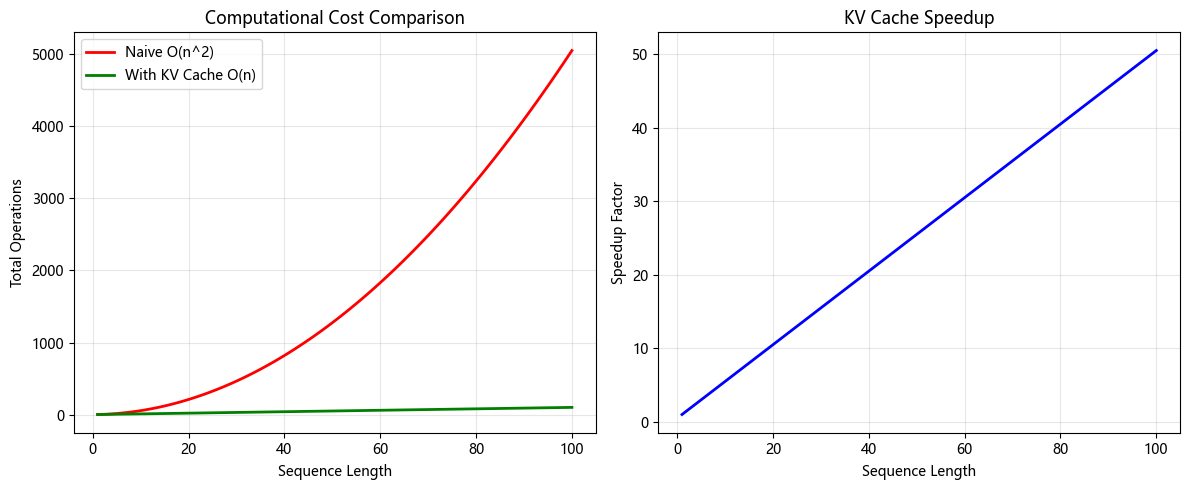

当序列长度为 100 时:
  朴素方法: 5050 次操作
  KV Cache: 100 次操作
  加速: 50.5x


In [2]:
# 可视化 O(n^2) 的问题
n = np.arange(1, 101)
naive_ops = n * (n + 1) / 2  # 1+2+...+n
cached_ops = n  # 每步只算1次

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(n, naive_ops, 'r-', linewidth=2, label='Naive O(n^2)')
plt.plot(n, cached_ops, 'g-', linewidth=2, label='With KV Cache O(n)')
plt.xlabel('Sequence Length')
plt.ylabel('Total Operations')
plt.title('Computational Cost Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
speedup = naive_ops / cached_ops
plt.plot(n, speedup, 'b-', linewidth=2)
plt.xlabel('Sequence Length')
plt.ylabel('Speedup Factor')
plt.title('KV Cache Speedup')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"当序列长度为 100 时:")
print(f"  朴素方法: {naive_ops[-1]:.0f} 次操作")
print(f"  KV Cache: {cached_ops[-1]:.0f} 次操作")
print(f"  加速: {speedup[-1]:.1f}x")

---

## 2. KV Cache 原理

### 关键洞察

在自回归生成中：
- **我们只需要当前 token 的输出**，因此只需要当前 token 的 Query（Q）
- **历史 token 的 Key/Value（K/V）不会改变**，可以直接复用

### 一步一步看“只算最后一个 Query”

| 步骤 | 输入序列 | 需要计算 | 复用缓存 |
|---|---|---|---|
| 1 | [A] | Q1, K1, V1 | 无 |
| 2 | [A, B] | Q2, K2, V2 | K1, V1 |
| 3 | [A, B, C] | Q3, K3, V3 | K1, V1, K2, V2 |

**核心点：** 生成阶段只关心“下一个 token”，所以只需要**最后一个 token 的 Query**。

### 训练 vs 推理（为何训练时不用 KV Cache）

- **训练**：一次性喂入全序列，需要所有 token 的 Q/K/V
- **推理**：逐 token 生成，只需要当前 token 的 Q，并复用历史 K/V

接下来用更直观的矩阵和图示来对比两种计算方式。

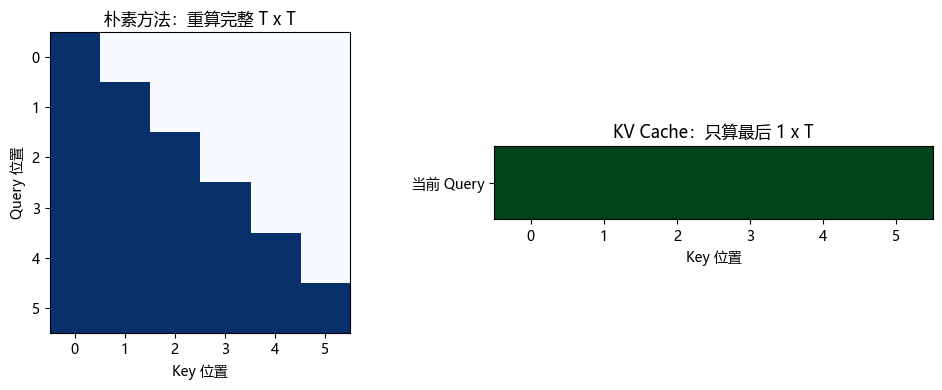

解释：生成时只需要最后一个 token 的输出，所以只算最后一行的注意力。


In [3]:
# 直观对比：Attention 矩阵需要算哪些部分
import matplotlib.pyplot as plt
import numpy as np

T = 6  # 序列长度

# 朴素方法：每步重新计算完整 T x T 注意力矩阵
naive = np.tril(np.ones((T, T)))

# KV Cache：只需要最后一个 Query，对应 1 x T 的注意力
cache = np.ones((1, T))

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].imshow(naive, cmap='Blues', vmin=0, vmax=1)
axes[0].set_title('朴素方法：重算完整 T x T')
axes[0].set_xlabel('Key 位置')
axes[0].set_ylabel('Query 位置')
axes[0].set_xticks(range(T))
axes[0].set_yticks(range(T))

axes[1].imshow(cache, cmap='Greens', vmin=0, vmax=1)
axes[1].set_title('KV Cache：只算最后 1 x T')
axes[1].set_xlabel('Key 位置')
axes[1].set_yticks([0])
axes[1].set_yticklabels(['当前 Query'])
axes[1].set_xticks(range(T))

plt.tight_layout()
plt.show()

print("解释：生成时只需要最后一个 token 的输出，所以只算最后一行的注意力。")

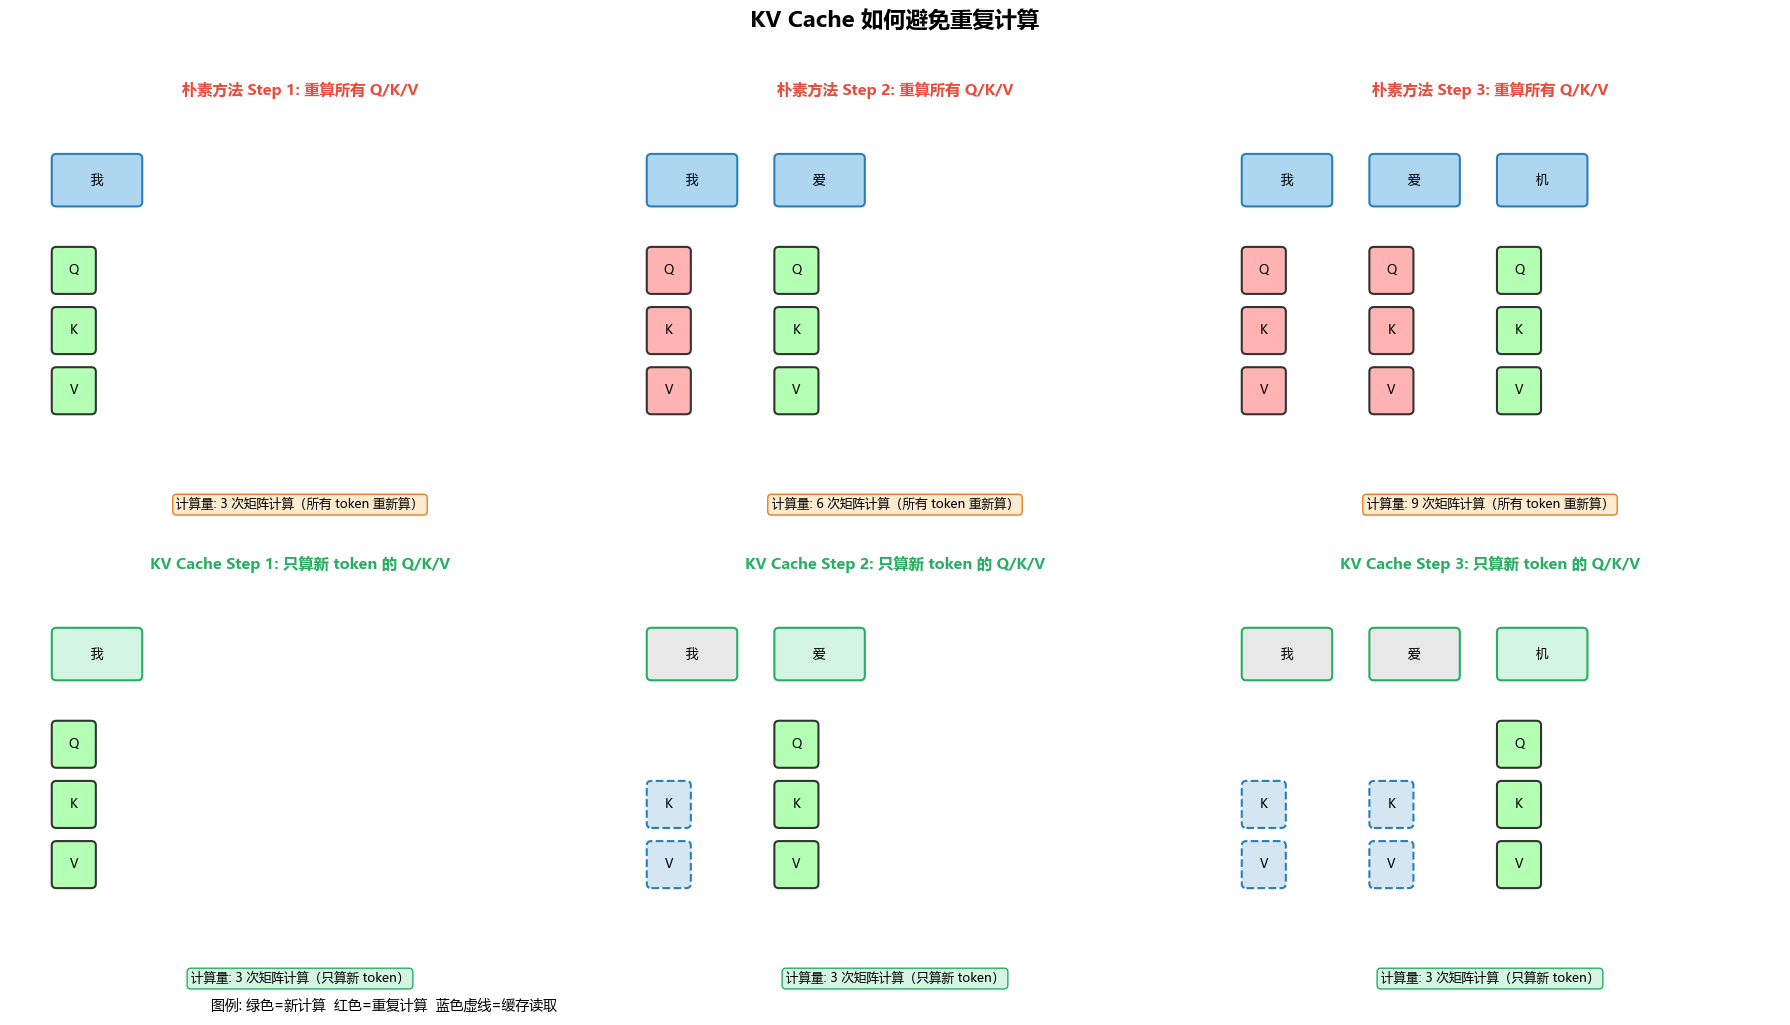


核心差异:
  朴素方法: 每一步都重算所有 token 的 Q/K/V
  KV Cache: 只算新 token 的 Q/K/V，旧 token 的 K/V 直接复用
  结果: 计算量从 O(n^2) 降到 O(n)


In [4]:
# KV Cache 工作原理可视化（更直观版）
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
import matplotlib as mpl

# 设置中文字体，避免乱码
mpl.rcParams["font.sans-serif"] = ["Microsoft YaHei", "SimHei", "Arial Unicode MS"]
mpl.rcParams["axes.unicode_minus"] = False


def _box(ax, x, y, w, h, text, fc, ec, ls="-"):
    patch = FancyBboxPatch((x, y), w, h, boxstyle="round,pad=0.08",
                           facecolor=fc, edgecolor=ec, linewidth=1.5, linestyle=ls)
    ax.add_patch(patch)
    ax.text(x + w / 2, y + h / 2, text, ha="center", va="center", fontsize=9)


def draw_step(ax, tokens, step, mode):
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 8)
    ax.axis("off")

    if mode == "naive":
        title = f"朴素方法 Step {step + 1}: 重算所有 Q/K/V"
        color = "#E74C3C"
    else:
        title = f"KV Cache Step {step + 1}: 只算新 token 的 Q/K/V"
        color = "#27AE60"

    ax.set_title(title, fontsize=11, fontweight="bold", color=color)

    for i, tok in enumerate(tokens):
        x = 0.8 + i * 2.2
        # token
        tok_color = "#AED6F1" if mode == "naive" else ("#D5F5E3" if i == step else "#E8E8E8")
        _box(ax, x, 6.2, 1.4, 0.8, tok, tok_color, "#2980B9" if mode == "naive" else "#27AE60")

        if mode == "naive":
            # 所有 token 都重算 Q/K/V
            repeat = i < step
            fc = "#FFB3B3" if repeat else "#B3FFB3"
            _box(ax, x, 4.6, 0.6, 0.7, "Q", fc, "#333")
            _box(ax, x, 3.5, 0.6, 0.7, "K", fc, "#333")
            _box(ax, x, 2.4, 0.6, 0.7, "V", fc, "#333")
        else:
            # 只算当前 token 的 Q/K/V；旧 token 的 K/V 从缓存读取
            if i == step:
                _box(ax, x, 4.6, 0.6, 0.7, "Q", "#B3FFB3", "#333")
                _box(ax, x, 3.5, 0.6, 0.7, "K", "#B3FFB3", "#333")
                _box(ax, x, 2.4, 0.6, 0.7, "V", "#B3FFB3", "#333")
            else:
                _box(ax, x, 3.5, 0.6, 0.7, "K", "#D4E6F1", "#2980B9", ls="--")
                _box(ax, x, 2.4, 0.6, 0.7, "V", "#D4E6F1", "#2980B9", ls="--")

    # 计算量说明
    if mode == "naive":
        calc = (step + 1) * 3
        note = f"计算量: {calc} 次矩阵计算（所有 token 重新算）"
        ax.text(5, 0.6, note, ha="center", fontsize=9,
                bbox=dict(boxstyle="round", facecolor="#FDEBD0", edgecolor="#E67E22"))
    else:
        note = "计算量: 3 次矩阵计算（只算新 token）"
        ax.text(5, 0.6, note, ha="center", fontsize=9,
                bbox=dict(boxstyle="round", facecolor="#D5F5E3", edgecolor="#27AE60"))


fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 上排：朴素方法
for step in range(3):
    tokens = ["我", "爱", "机"][: step + 1]
    draw_step(axes[0, step], tokens, step, mode="naive")

# 下排：KV Cache 方法
for step in range(3):
    tokens = ["我", "爱", "机"][: step + 1]
    draw_step(axes[1, step], tokens, step, mode="cache")

# 图例
fig.text(0.12, 0.02, "图例: 绿色=新计算  红色=重复计算  蓝色虚线=缓存读取", fontsize=10, ha="left")

plt.suptitle("KV Cache 如何避免重复计算", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

print("\n核心差异:")
print("  朴素方法: 每一步都重算所有 token 的 Q/K/V")
print("  KV Cache: 只算新 token 的 Q/K/V，旧 token 的 K/V 直接复用")
print("  结果: 计算量从 O(n^2) 降到 O(n)")

In [5]:
class CausalSelfAttentionWithCache(nn.Module):
    """
    带 KV Cache 的自注意力
    """
    def __init__(self, n_embd, n_head, block_size, dropout=0.1):
        super().__init__()
        self.n_head = n_head
        self.head_dim = n_embd // n_head
        
        self.c_attn = nn.Linear(n_embd, 3 * n_embd)
        self.c_proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)
        
        # Causal mask
        self.register_buffer("mask", torch.tril(
            torch.ones(block_size, block_size)
        ).view(1, 1, block_size, block_size))
    
    def forward(self, x, past_kv=None, use_cache=False):
        """
        x: [B, T, C] 输入（如果 use_cache=True 且 past_kv 存在，T=1）
        past_kv: tuple of (past_k, past_v)，之前的 K 和 V 缓存
        use_cache: 是否使用和更新缓存
        
        返回:
            output: [B, T, C]
            present_kv: 更新后的缓存（如果 use_cache=True）
        """
        B, T, C = x.size()
        
        # 计算当前的 Q, K, V
        q, k, v = self.c_attn(x).split(C, dim=2)
        
        # 如果有缓存，拼接
        if past_kv is not None:
            past_k, past_v = past_kv
            k = torch.cat([past_k, k], dim=1)  # [B, past_T + T, C]
            v = torch.cat([past_v, v], dim=1)
        
        # 当前的 K, V 就是 present（用于下一次的缓存）
        present_kv = (k, v) if use_cache else None
        
        # 获取完整序列长度
        full_T = k.size(1)
        
        # Reshape for multi-head attention
        q = q.view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        k = k.view(B, full_T, self.n_head, self.head_dim).transpose(1, 2)
        v = v.view(B, full_T, self.n_head, self.head_dim).transpose(1, 2)
        
        # Attention
        att = (q @ k.transpose(-2, -1)) / np.sqrt(self.head_dim)
        
        # 只 mask 新 query 能看到的范围
        # query 位置 [full_T - T : full_T]，key 位置 [0 : full_T]
        if T == 1:
            # 生成时只有一个 query，可以看到所有之前的 key
            pass  # 不需要 mask
        else:
            att = att.masked_fill(self.mask[:, :, :T, :full_T] == 0, float('-inf'))
        
        att = F.softmax(att, dim=-1)
        att = self.dropout(att)
        
        y = (att @ v).transpose(1, 2).contiguous().view(B, T, C)
        output = self.c_proj(y)
        
        return output, present_kv

# 测试
attn = CausalSelfAttentionWithCache(n_embd=64, n_head=4, block_size=128)

# 模拟增量生成
x_full = torch.randn(1, 10, 64)  # 完整序列
x_new = torch.randn(1, 1, 64)   # 新 token

# 无缓存
out1, _ = attn(x_full, use_cache=False)
print(f"无缓存输出形状: {out1.shape}")

# 有缓存
out2, cache = attn(x_full, use_cache=True)
out3, new_cache = attn(x_new, past_kv=cache, use_cache=True)
print(f"有缓存时新 token 输出: {out3.shape}")
print(f"缓存 K 形状: {new_cache[0].shape}")

无缓存输出形状: torch.Size([1, 10, 64])
有缓存时新 token 输出: torch.Size([1, 1, 64])
缓存 K 形状: torch.Size([1, 11, 64])


---

## 3. 完整的 GPT with KV Cache

In [6]:
class GPTWithCache(nn.Module):
    """带 KV Cache 的 GPT"""
    def __init__(self, vocab_size, block_size, n_layer, n_head, n_embd, dropout=0.1):
        super().__init__()
        self.block_size = block_size
        self.n_layer = n_layer
        
        self.wte = nn.Embedding(vocab_size, n_embd)
        self.wpe = nn.Embedding(block_size, n_embd)
        self.drop = nn.Dropout(dropout)
        
        # Transformer blocks with cache support
        self.blocks = nn.ModuleList([
            nn.ModuleDict({
                'ln_1': nn.LayerNorm(n_embd),
                'attn': CausalSelfAttentionWithCache(n_embd, n_head, block_size, dropout),
                'ln_2': nn.LayerNorm(n_embd),
                'mlp': nn.Sequential(
                    nn.Linear(n_embd, 4 * n_embd),
                    nn.GELU(),
                    nn.Linear(4 * n_embd, n_embd),
                    nn.Dropout(dropout),
                )
            })
            for _ in range(n_layer)
        ])
        
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size, bias=False)
        self.wte.weight = self.lm_head.weight
    
    def forward(self, idx, past_kv_list=None, use_cache=False):
        B, T = idx.size()
        
        # Position IDs
        if past_kv_list is not None:
            past_length = past_kv_list[0][0].size(1)
            pos = torch.arange(past_length, past_length + T, device=idx.device)
        else:
            pos = torch.arange(0, T, device=idx.device)
        
        # Embeddings
        x = self.drop(self.wte(idx) + self.wpe(pos))
        
        # Transformer blocks
        present_kv_list = []
        for i, block in enumerate(self.blocks):
            past_kv = past_kv_list[i] if past_kv_list else None
            
            attn_out, present_kv = block['attn'](
                block['ln_1'](x), 
                past_kv=past_kv, 
                use_cache=use_cache
            )
            x = x + attn_out
            x = x + block['mlp'](block['ln_2'](x))
            
            if use_cache:
                present_kv_list.append(present_kv)
        
        x = self.ln_f(x)
        logits = self.lm_head(x)
        
        return logits, present_kv_list if use_cache else None

# 创建模型
model = GPTWithCache(
    vocab_size=100,
    block_size=128,
    n_layer=4,
    n_head=4,
    n_embd=64
).to(device)

print(f"模型参数量: {sum(p.numel() for p in model.parameters()):,}")

模型参数量: 214,656


---

## 4. 性能对比

In [7]:
@torch.no_grad()
def generate_naive(model, idx, max_new_tokens):
    """朴素生成（无缓存）"""
    for _ in range(max_new_tokens):
        # 每次都处理完整序列
        logits, _ = model(idx, use_cache=False)
        logits = logits[:, -1, :]
        probs = F.softmax(logits, dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

@torch.no_grad()
def generate_with_cache(model, idx, max_new_tokens):
    """带 KV Cache 的生成"""
    # 首先处理 prompt
    logits, past_kv = model(idx, use_cache=True)
    logits = logits[:, -1, :]
    probs = F.softmax(logits, dim=-1)
    idx_next = torch.multinomial(probs, num_samples=1)
    idx = torch.cat((idx, idx_next), dim=1)
    
    # 后续只处理新 token
    for _ in range(max_new_tokens - 1):
        logits, past_kv = model(idx_next, past_kv_list=past_kv, use_cache=True)
        logits = logits[:, -1, :]
        probs = F.softmax(logits, dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, idx_next), dim=1)
    
    return idx

# 预热
prompt = torch.randint(0, 100, (1, 10)).to(device)
_ = generate_with_cache(model, prompt.clone(), 10)

# 测试不同长度
lengths = [10, 20, 30, 40, 50]
naive_times = []
cache_times = []

print("性能测试...")
for length in lengths:
    # 朴素方法
    prompt = torch.randint(0, 100, (1, 10)).to(device)
    start = time.time()
    _ = generate_naive(model, prompt.clone(), length)
    naive_times.append(time.time() - start)
    
    # KV Cache
    start = time.time()
    _ = generate_with_cache(model, prompt.clone(), length)
    cache_times.append(time.time() - start)
    
    print(f"生成 {length} tokens: Naive={naive_times[-1]:.3f}s, Cache={cache_times[-1]:.3f}s, Speedup={naive_times[-1]/cache_times[-1]:.1f}x")

性能测试...
生成 10 tokens: Naive=0.029s, Cache=0.013s, Speedup=2.3x
生成 20 tokens: Naive=0.035s, Cache=0.028s, Speedup=1.3x
生成 30 tokens: Naive=0.049s, Cache=0.041s, Speedup=1.2x
生成 40 tokens: Naive=0.070s, Cache=0.054s, Speedup=1.3x
生成 50 tokens: Naive=0.085s, Cache=0.080s, Speedup=1.1x


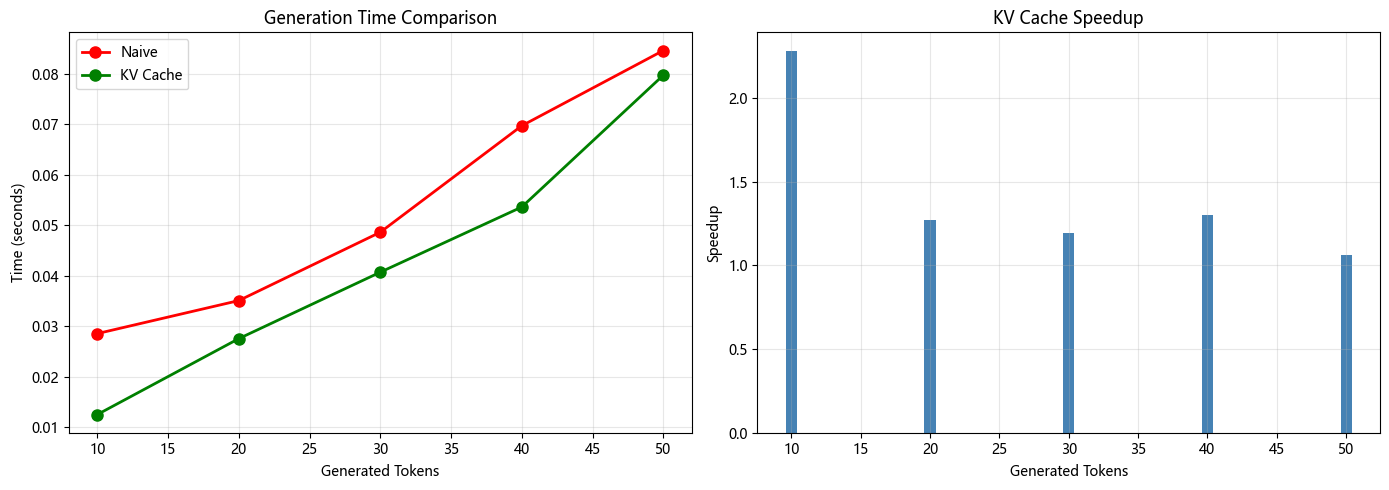

In [8]:
# 可视化性能对比
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 时间对比
axes[0].plot(lengths, naive_times, 'ro-', linewidth=2, markersize=8, label='Naive')
axes[0].plot(lengths, cache_times, 'go-', linewidth=2, markersize=8, label='KV Cache')
axes[0].set_xlabel('Generated Tokens')
axes[0].set_ylabel('Time (seconds)')
axes[0].set_title('Generation Time Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 加速比
speedups = [n/c for n, c in zip(naive_times, cache_times)]
axes[1].bar(lengths, speedups, color='steelblue')
axes[1].set_xlabel('Generated Tokens')
axes[1].set_ylabel('Speedup')
axes[1].set_title('KV Cache Speedup')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## 5. KV Cache 内存分析

这些数字是**理论估算**，表示推理时 KV cache 的显存需求：
- 不包含模型权重、优化器状态或激活
- 与 batch_size、seq_len、层数、head_dim、精度线性相关
- 如果模型使用 GQA/MQA，用 num_key_value_heads 替代 num_attention_heads

公式：
`KV = 2 * n_layer * batch * n_kv_head * seq_len * head_dim * dtype_bytes`

这是理论计算值（非实测）。假设 batch_size=1, seq_len=2048, fp16。
公式: 2 * n_layer * batch * n_kv_head * seq_len * head_dim * dtype_bytes
KV Cache 内存占用:
Qwen2.5-0.5B    :     24.0 MB (0.02 GB) | layers=24, heads=14, kv_heads=2 | Qwen/Qwen2.5-0.5B-Instruct
Qwen2.5-1.5B    :     56.0 MB (0.05 GB) | layers=28, heads=12, kv_heads=2 | Qwen/Qwen2.5-1.5B-Instruct
GPT-2 Small     :     72.0 MB (0.07 GB) | layers=12, heads=12, kv_heads=12 | gpt2
Qwen2.5-7B      :    112.0 MB (0.11 GB) | layers=28, heads=28, kv_heads=4 | Qwen/Qwen2.5-7B-Instruct
ERNIE-4.5-21B   :    112.0 MB (0.11 GB) | layers=28, heads=20, kv_heads=4 | baidu/ERNIE-4.5-21B-A3B-PT
GPT-2 Medium    :    192.0 MB (0.19 GB) | layers=24, heads=16, kv_heads=16 | gpt2-medium
GPT-2 Large     :    360.0 MB (0.35 GB) | layers=36, heads=20, kv_heads=20 | gpt2-large
DeepSeek-LLM-67B:    760.0 MB (0.74 GB) | layers=95, heads=64, kv_heads=8 | deepseek-ai/deepseek-llm-67b-base
DeepSeek-LLM-7B :    960.0 MB (0.94 GB) | layers=30, heads=32, kv_heads=32 | deepseek

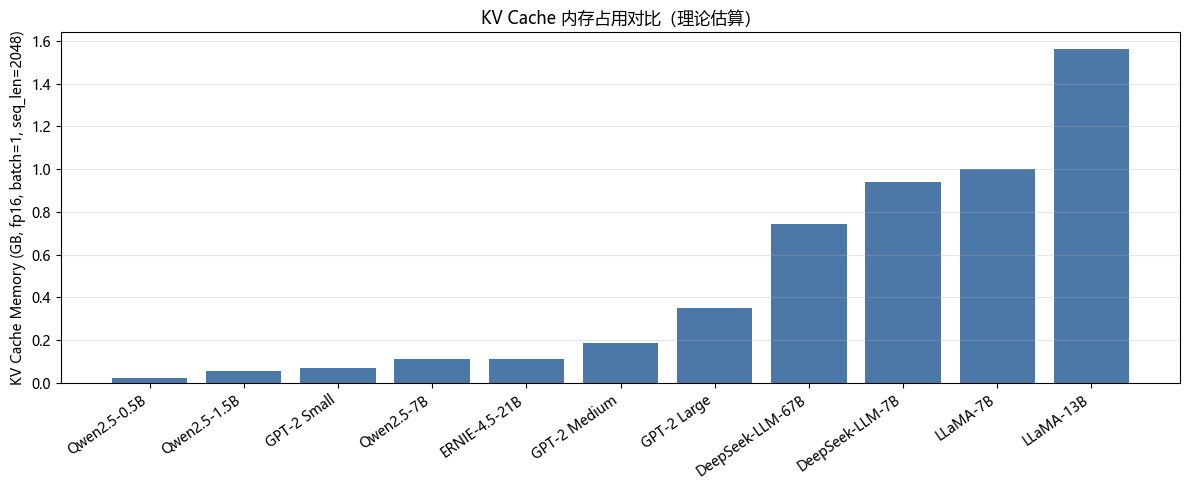

In [9]:
# 计算 KV Cache 内存占用（理论估算）
import matplotlib.pyplot as plt
from transformers import AutoConfig


def calculate_kv_cache_memory(batch_size, seq_len, n_layer, n_head, head_dim, dtype_bytes=2, n_kv_head=None):
    """
    计算 KV Cache 内存占用
    dtype_bytes: 2 for fp16, 4 for fp32
    n_kv_head: GQA/MQA 的 KV 头数，缺省时等于 n_head
    """
    kv_heads = n_kv_head if n_kv_head is not None else n_head
    kv_size = 2 * batch_size * kv_heads * seq_len * head_dim * dtype_bytes
    total_size = n_layer * kv_size
    return total_size


def load_spec_from_hf(model_id):
    cfg = AutoConfig.from_pretrained(model_id, trust_remote_code=True)
    n_layer = cfg.num_hidden_layers
    n_head = cfg.num_attention_heads
    head_dim = cfg.hidden_size // cfg.num_attention_heads
    n_kv_head = getattr(cfg, "num_key_value_heads", n_head)
    return dict(n_layer=n_layer, n_head=n_head, n_kv_head=n_kv_head, head_dim=head_dim)


model_ids = {
    "GPT-2 Small": "gpt2",
    "GPT-2 Medium": "gpt2-medium",
    "GPT-2 Large": "gpt2-large",
    "LLaMA-7B": "meta-llama/Llama-2-7b-hf",
    "LLaMA-13B": "meta-llama/Llama-2-13b-hf",
    "Qwen2.5-0.5B": "Qwen/Qwen2.5-0.5B-Instruct",
    "Qwen2.5-1.5B": "Qwen/Qwen2.5-1.5B-Instruct",
    "Qwen2.5-7B": "Qwen/Qwen2.5-7B-Instruct",
    "DeepSeek-LLM-7B": "deepseek-ai/deepseek-llm-7b-base",
    "DeepSeek-LLM-67B": "deepseek-ai/deepseek-llm-67b-base",
    "ERNIE-4.5-21B": "baidu/ERNIE-4.5-21B-A3B-PT",
}

# 兜底配置（HF 无法下载时使用）
fallback_specs = {
    "GPT-2 Small": {"n_layer": 12, "n_head": 12, "head_dim": 64, "n_kv_head": 12},
    "GPT-2 Medium": {"n_layer": 24, "n_head": 16, "head_dim": 64, "n_kv_head": 16},
    "GPT-2 Large": {"n_layer": 36, "n_head": 20, "head_dim": 64, "n_kv_head": 20},
    "LLaMA-7B": {"n_layer": 32, "n_head": 32, "head_dim": 128, "n_kv_head": 32},
    "LLaMA-13B": {"n_layer": 40, "n_head": 40, "head_dim": 128, "n_kv_head": 40},
}

batch_size = 1
seq_len = 2048  # 常见上下文长度

data = []
for name, model_id in model_ids.items():
    try:
        spec = load_spec_from_hf(model_id)
        source = model_id
    except Exception as e:
        if name in fallback_specs:
            spec = fallback_specs[name]
            source = "fallback"
        else:
            print(f"跳过 {name}: {e}")
            continue

    mem = calculate_kv_cache_memory(
        batch_size=batch_size,
        seq_len=seq_len,
        n_layer=spec["n_layer"],
        n_head=spec["n_head"],
        head_dim=spec["head_dim"],
        n_kv_head=spec.get("n_kv_head"),
    )
    data.append((name, mem, spec, source))

# 按内存排序
if not data:
    raise ValueError("未能加载任何模型配置，请检查网络或模型 ID")

data.sort(key=lambda x: x[1])

print("这是理论计算值（非实测）。假设 batch_size=1, seq_len=2048, fp16。")
print("公式: 2 * n_layer * batch * n_kv_head * seq_len * head_dim * dtype_bytes")
print("KV Cache 内存占用:")
print("=" * 80)

for name, mem, spec, source in data:
    mb = mem / 1024**2
    gb = mem / 1024**3
    print(
        f"{name:16s}: {mb:8.1f} MB ({gb:.2f} GB) | "
        f"layers={spec['n_layer']}, heads={spec['n_head']}, kv_heads={spec.get('n_kv_head', spec['n_head'])} | {source}"
    )

# 绘图
labels = [d[0] for d in data]
values_gb = [d[1] / 1024**3 for d in data]

plt.figure(figsize=(12, 5))
plt.bar(range(len(labels)), values_gb, color="#4C78A8")
plt.xticks(range(len(labels)), labels, rotation=35, ha="right")
plt.ylabel("KV Cache Memory (GB, fp16, batch=1, seq_len=2048)")
plt.title("KV Cache 内存占用对比（理论估算）")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

---

## 本章总结


1. **问题根源**
   - 朴素实现是 O(n^2) 复杂度
   - 每次生成都重复计算之前的 K, V

2. **KV Cache 原理**
   - 缓存之前 token 的 K 和 V
   - 每次只计算新 token
   - 复杂度降为 O(n)

3. **工程实现**
   - 修改 forward 支持 past_kv
   - 正确处理 position id
   - 注意内存占用


---

## 练习题

1. **内存优化**：实现滑动窗口 KV Cache
2. **量化缓存**：用 int8 存储 K, V 减少内存
3. **思考题**：为什么 Flash Attention 不需要显式 KV Cache？

In [10]:
# 练习空间

